In [16]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from datetime import datetime

# Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
data = pd.read_csv('../raw_data/inViales_completa.csv')

# Drop duplicates
data = data[data.drop(columns='folio').duplicated() == False]


# FOR NOW DROP THE 'D' CLASS IN codigo_cierre
data = data[(data['codigo_cierre'] == 'D') == False]


# Drop unimportant columns
data = data.drop(columns=['folio', 'fecha_cierre', 'hora_cierre', 'clas_con_f_alarma', 'alcaldia_cierre', 'colonia'])

# fin_semana 
fin_semana = (data['dia_semana'] == 'Viernes') | (data['dia_semana'] == 'Sábado') | (data['dia_semana'] == 'Domingo')
data['fin_semana'] = fin_semana
data['fin_semana'] = data['fin_semana'].replace({True: 1, False : 0})


# alcaldia_inicio imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
imputer.fit(data[['alcaldia_inicio']])
data[['alcaldia_inicio']] = imputer.transform(data[['alcaldia_inicio']])


# # colonia imputer
# imputer = SimpleImputer(strategy="most_frequent") 
# imputer.fit(data[['colonia']])
# data[['colonia']] = imputer.transform(data[['colonia']])


# hora_creacion imputer
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(data[['hora_creacion']])
data[['hora_creacion']] = imputer.transform(data[['hora_creacion']])


# hora_pico
data['hora_creacion'] = pd.to_timedelta(data['hora_creacion'])
data['hora_creacion'] = data['hora_creacion'].dt.total_seconds() / (60 * 60)

# Create sin & cos columns to help Machine Learning algorithm to capture this cyclicity
data['sin_enc_hora_creacion'] = np.sin(2*np.pi*data.hora_creacion/24) # 12 months in a year
data['cos_enc_hora_creacion'] = np.cos(2*np.pi*data.hora_creacion/24)

def hora_pico(row):
    hour_calc = row['hora_creacion']
    if hour_calc >= 7.5 and hour_calc <= 9.5:  # Verificar la hora entre 07:30 y 09:30
        return 1
    elif row['fecha_creacion'][:4] >= '2021' and (hour_calc >= 14 and hour_calc <= 15):  # A partir de marzo de 2020, verificar la hora entre 14:00 y 15:00
        return 1
    elif hour_calc >= 18 and hour_calc <= 19:  # Verificar la hora entre 18:00 y 19:00
        return 1
    else:
        return 0

data['hora_pico'] = data.apply(hora_pico, axis=1)

data['viernes_noche'] = (((data['dia_semana'] == 'Viernes') & (data['hora_creacion'] >= 20)) |
                                ((data['dia_semana'] == 'Sábado') & (data['hora_creacion'] < 3))).astype(int)

data['sabado_noche'] = (((data['dia_semana'] == 'Sábado') & (data['hora_creacion'] >= 20)) |
                                ((data['dia_semana'] == 'Domingo') & (data['hora_creacion'] < 3))).astype(int)



# ids_clasificacion completely correlated with alcaldia_inicio
# classification_dict = {
#     "AZCAPOTZALCO": 0.8786,
#     "COYOACAN": 0.8761,
#     "CUAJIMALPA DE MORELOS": 0.8422,
#     "GUSTAVO A. MADERO": 0.8401,
#     "IZTACALCO": 0.8494,
#     "IZTAPALAPA": 0.8030,
#     "LA MAGDALENA CONTRERAS": 0.8269,
#     "MILPA ALTA": 0.7582,
#     "ALVARO OBREGON": 0.8455,
#     "TLAHUAC": 0.8088,
#     "TLALPAN": 0.8309,
#     "XOCHIMILCO": 0.8026,
#     "BENITO JUAREZ": 0.9321,
#     "CUAUHTEMOC": 0.8483,
#     "MIGUEL HIDALGO": 0.8943,
#     "VENUSTIANO CARRANZA": 0.8355
# }
# data['ids_clasificacion'] = data['alcaldia_inicio'].map(classification_dict)


# dias_festivos
dias_festivos = ['01-01', '02-05', '03-21', '05-01', '08-16', '12-25']
def festividades(d):
    if d[5:] in dias_festivos:
        return 1
    return 0

data['dia_festivo'] = data['fecha_creacion'].apply(festividades)


# incidente_c4 class reduction
incidente_c4_dict = {
    'Incidente de tránsito': 'Choque sin lesionados',
    'Accidente automovilístico': 'Choque sin lesionados',
    'Choque con prensados': 'Choque con lesionados',
    'Persona atropellada': 'Atropellado',
    'Volcadura': 'Volcadura',
    'Monopatín': 'Ciclista',
    'Vehiculo atrapado': 'Vehículo atrapadovarado',
    'Vehiculo desbarrancado': 'Vehículo atrapadovarado',
    'Ferroviario': 'Vehículo atrapadovarado'
}
data['incidente_c4'] = data['incidente_c4'].replace(incidente_c4_dict)


# tipo_incidentes_c4 class reduction
tipo_incidente_c4_dict = {
    'Detención ciudadana': 'Accidente',
    'Sismo': 'Accidente',
    'Mi Calle': 'Accidente',
    'Mi Taxi': 'Accidente'
}
data['tipo_incidente_c4'] = data['tipo_incidente_c4'].replace(tipo_incidente_c4_dict)


# tipo_entrada class reduction
tipo_entrada_dict = {
    'LLAMADA APP911': 'LLAMADA DEL 911',
    'LLAMADA DEL 066': 'LLAMADA DEL 911',
    'BOTÓN DE AUXILIO': 'BOTÓN DE AUXILIO',
    'ZELLO': 'RADIO',
    'LECTOR DE PLACAS': 'CÁMARA',
    'APLICATIVOS': 'RADIO',
}
data['tipo_entrada'] = data['tipo_entrada'].replace(tipo_entrada_dict)


# tipo_entrada imputer
data['tipo_entrada'].fillna('LLAMADA DEL 911', inplace=True)


# OHE
# dia_semana encoder
ohe = OneHotEncoder(sparse_output= False, drop='if_binary')
ohe.fit(data[['dia_semana']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['dia_semana']])
data.drop(columns = ["dia_semana"], inplace=True)


# tipo_entrada encoder
ohe = OneHotEncoder(sparse_output= False, drop='if_binary')
ohe.fit(data[['tipo_entrada']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['tipo_entrada']])
data.drop(columns = ["tipo_entrada"], inplace=True)


# alcaldia_inicio encoder
ohe = OneHotEncoder(sparse_output= False, drop='if_binary')
ohe.fit(data[['alcaldia_inicio']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['alcaldia_inicio']])
data.drop(columns = ["alcaldia_inicio"], inplace=True)


# tipo_incidente C4 encoder
ohe = OneHotEncoder(sparse_output= False, drop='if_binary')
ohe.fit(data[['tipo_incidente_c4']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['tipo_incidente_c4']])
data.drop(columns = ['tipo_incidente_c4'], inplace=True)


# incidente_C4 encoder
ohe = OneHotEncoder(sparse_output= False, drop='if_binary')
ohe.fit(data[['incidente_c4']])
data[ohe.get_feature_names_out()] = ohe.transform(data[['incidente_c4']])
data.drop(columns = ['incidente_c4'], inplace=True)


# Create Binary class for 'A' vs 'I','N','F'
codigo_cierre_binario = {
    'A' : 1,
    'I' : 0,
    'N' : 0,
    'F' : 0
}
data['codigo_cierre_binario'] = data['codigo_cierre'].replace(codigo_cierre_binario)


# export to csv
# data.to_csv('data911.csv', index=False)

In [18]:
pd.set_option('display.max_columns', len(data.columns))
data.head()

,fecha_creacion,hora_creacion,latitud,longitud,codigo_cierre,fin_semana,sin_enc_hora_creacion,cos_enc_hora_creacion,hora_pico,viernes_noche,sabado_noche,dia_festivo,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miércoles,dia_semana_Sábado,dia_semana_Viernes,tipo_entrada_BOTÓN DE AUXILIO,tipo_entrada_CÁMARA,tipo_entrada_LLAMADA DEL 911,tipo_entrada_RADIO,tipo_entrada_REDES,alcaldia_inicio_ALVARO OBREGON,alcaldia_inicio_AZCAPOTZALCO,alcaldia_inicio_BENITO JUAREZ,alcaldia_inicio_COYOACAN,alcaldia_inicio_CUAJIMALPA DE MORELOS,alcaldia_inicio_CUAUHTEMOC,alcaldia_inicio_GUSTAVO A. MADERO,alcaldia_inicio_IZTACALCO,alcaldia_inicio_IZTAPALAPA,alcaldia_inicio_LA MAGDALENA CONTRERAS,alcaldia_inicio_MIGUEL HIDALGO,alcaldia_inicio_MILPA ALTA,alcaldia_inicio_TLAHUAC,alcaldia_inicio_TLALPAN,alcaldia_inicio_VENUSTIANO CARRANZA,alcaldia_inicio_XOCHIMILCO,tipo_incidente_c4_Accidente,tipo_incidente_c4_Cadáver,tipo_incidente_c4_Lesionado,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura,codigo_cierre_binario
0,2014-01-01,13.413333,19.38090,-99.06104,A,0,-0.361625,-0.932324,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2014-01-01,21.749722,19.49053,-99.10342,A,0,-0.555631,0.831429,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2013-12-31,22.053611,19.32276,-99.04830,I,0,-0.487796,0.872958,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2013-12-31,22.748056,19.31469,-99.07113,I,0,-0.321921,0.946766,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2014-01-01,21.761944,19.36336,-99.19104,A,0,-0.552967,0.833203,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [19]:
data_sample = data.sample(frac=0.1, random_state=42)
data_sample

,fecha_creacion,hora_creacion,latitud,longitud,codigo_cierre,fin_semana,sin_enc_hora_creacion,cos_enc_hora_creacion,hora_pico,viernes_noche,sabado_noche,dia_festivo,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miércoles,dia_semana_Sábado,dia_semana_Viernes,tipo_entrada_BOTÓN DE AUXILIO,tipo_entrada_CÁMARA,tipo_entrada_LLAMADA DEL 911,tipo_entrada_RADIO,tipo_entrada_REDES,alcaldia_inicio_ALVARO OBREGON,alcaldia_inicio_AZCAPOTZALCO,alcaldia_inicio_BENITO JUAREZ,alcaldia_inicio_COYOACAN,alcaldia_inicio_CUAJIMALPA DE MORELOS,alcaldia_inicio_CUAUHTEMOC,alcaldia_inicio_GUSTAVO A. MADERO,alcaldia_inicio_IZTACALCO,alcaldia_inicio_IZTAPALAPA,alcaldia_inicio_LA MAGDALENA CONTRERAS,alcaldia_inicio_MIGUEL HIDALGO,alcaldia_inicio_MILPA ALTA,alcaldia_inicio_TLAHUAC,alcaldia_inicio_TLALPAN,alcaldia_inicio_VENUSTIANO CARRANZA,alcaldia_inicio_XOCHIMILCO,tipo_incidente_c4_Accidente,tipo_incidente_c4_Cadáver,tipo_incidente_c4_Lesionado,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura,codigo_cierre_binario
1077793,2019-04-05,16.363889,19.396580,-99.056590,N,1,-0.909659,-0.415355,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1666865,2022-04-10,14.986944,19.341158,-99.137568,A,1,-0.704686,-0.709519,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
391204,2016-03-13,4.366667,19.431960,-99.102720,A,1,0.909961,0.414693,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1751010,2022-08-23,18.501944,19.399749,-99.187305,F,0,-0.991378,0.131031,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1241627,2019-12-18,3.504167,19.531100,-99.141850,A,0,0.794017,0.607896,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304205,2020-04-02,11.315833,19.345560,-99.011660,N,0,0.178158,-0.984002,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
535150,2016-12-09,22.204167,19.363170,-99.057400,N,1,-0.453018,0.891501,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
226078,2015-04-26,2.374444,19.304320,-99.087140,I,1,0.582359,0.812931,0,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1890331,2023-03-16,11.715556,19.445440,-99.147550,F,0,0.074399,-0.997229,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [20]:
data.columns

Index(['fecha_creacion', 'hora_creacion', 'latitud', 'longitud',
       'codigo_cierre', 'fin_semana', 'sin_enc_hora_creacion',
       'cos_enc_hora_creacion', 'hora_pico', 'viernes_noche', 'sabado_noche',
       'dia_festivo', 'dia_semana_Domingo', 'dia_semana_Jueves',
       'dia_semana_Lunes', 'dia_semana_Martes', 'dia_semana_Miércoles',
       'dia_semana_Sábado', 'dia_semana_Viernes',
       'tipo_entrada_BOTÓN DE AUXILIO', 'tipo_entrada_CÁMARA',
       'tipo_entrada_LLAMADA DEL 911', 'tipo_entrada_RADIO',
       'tipo_entrada_REDES', 'alcaldia_inicio_ALVARO OBREGON',
       'alcaldia_inicio_AZCAPOTZALCO', 'alcaldia_inicio_BENITO JUAREZ',
       'alcaldia_inicio_COYOACAN', 'alcaldia_inicio_CUAJIMALPA DE MORELOS',
       'alcaldia_inicio_CUAUHTEMOC', 'alcaldia_inicio_GUSTAVO A. MADERO',
       'alcaldia_inicio_IZTACALCO', 'alcaldia_inicio_IZTAPALAPA',
       'alcaldia_inicio_LA MAGDALENA CONTRERAS',
       'alcaldia_inicio_MIGUEL HIDALGO', 'alcaldia_inicio_MILPA ALTA',
       'alca

In [21]:
data.shape

(1224575, 53)

In [22]:
(data['codigo_cierre_binario'].value_counts())
#/len(data['codigo_cierre_binario'])

codigo_cierre_binario
1    816864
0    407711
Name: count, dtype: int64

In [23]:
data_sample['fecha_creacion'] = pd.to_datetime(data_sample['fecha_creacion'])

In [24]:
# incidentes_por_fecha = data_sample.groupby(['fecha_creacion']).sum()[['incidente_c4_Atropellado', 'incidente_c4_Choque con lesionados', 'incidente_c4_Choque sin lesionados', 'incidente_c4_Ciclista', 'incidente_c4_Motociclista', 'incidente_c4_Otros', 'incidente_c4_Persona atrapada / desbarrancada', 'incidente_c4_Vehículo atrapadovarado', 'incidente_c4_Volcadura']]

# incidentes_por_fecha.plot(kind='bar', stacked=True, figsize=(20, 6))
# plt.title('Tendencia de Incidentes por Fecha')
# plt.xlabel('Fecha de Creación')
# plt.ylabel('Cantidad de Incidentes')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# # Muestra la gráfica
# plt.show()

In [25]:
data_sample.dtypes

fecha_creacion                                   datetime64[ns]
hora_creacion                                           float64
latitud                                                 float64
longitud                                                float64
codigo_cierre                                            object
fin_semana                                                int64
sin_enc_hora_creacion                                   float64
cos_enc_hora_creacion                                   float64
hora_pico                                                 int64
viernes_noche                                             int64
sabado_noche                                              int64
dia_festivo                                               int64
dia_semana_Domingo                                      float64
dia_semana_Jueves                                       float64
dia_semana_Lunes                                        float64
dia_semana_Martes                       

In [26]:
data_sample['incidente_c4_Atropellado'].value_counts()

incidente_c4_Atropellado
0.0    108574
1.0     13884
Name: count, dtype: int64

In [27]:
data_sample.head()

,fecha_creacion,hora_creacion,latitud,longitud,codigo_cierre,fin_semana,sin_enc_hora_creacion,cos_enc_hora_creacion,hora_pico,viernes_noche,sabado_noche,dia_festivo,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miércoles,dia_semana_Sábado,dia_semana_Viernes,tipo_entrada_BOTÓN DE AUXILIO,tipo_entrada_CÁMARA,tipo_entrada_LLAMADA DEL 911,tipo_entrada_RADIO,tipo_entrada_REDES,alcaldia_inicio_ALVARO OBREGON,alcaldia_inicio_AZCAPOTZALCO,alcaldia_inicio_BENITO JUAREZ,alcaldia_inicio_COYOACAN,alcaldia_inicio_CUAJIMALPA DE MORELOS,alcaldia_inicio_CUAUHTEMOC,alcaldia_inicio_GUSTAVO A. MADERO,alcaldia_inicio_IZTACALCO,alcaldia_inicio_IZTAPALAPA,alcaldia_inicio_LA MAGDALENA CONTRERAS,alcaldia_inicio_MIGUEL HIDALGO,alcaldia_inicio_MILPA ALTA,alcaldia_inicio_TLAHUAC,alcaldia_inicio_TLALPAN,alcaldia_inicio_VENUSTIANO CARRANZA,alcaldia_inicio_XOCHIMILCO,tipo_incidente_c4_Accidente,tipo_incidente_c4_Cadáver,tipo_incidente_c4_Lesionado,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura,codigo_cierre_binario
1077793,2019-04-05,16.363889,19.396580,-99.056590,N,1,-0.909659,-0.415355,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1666865,2022-04-10,14.986944,19.341158,-99.137568,A,1,-0.704686,-0.709519,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
391204,2016-03-13,4.366667,19.431960,-99.102720,A,1,0.909961,0.414693,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1751010,2022-08-23,18.501944,19.399749,-99.187305,F,0,-0.991378,0.131031,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1241627,2019-12-18,3.504167,19.531100,-99.141850,A,0,0.794017,0.607896,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [28]:
# data_sample['hora_creacion'] = data['hora_creacion'] * (60 * 60)
# data_sample['hora_creacion'] = pd.to_timedelta(data_sample['hora_creacion'], unit='s')
# data_sample.head()

In [29]:
data_sample2 = data_sample.drop('fecha_creacion', axis=1)
data_sample2.head()

,hora_creacion,latitud,longitud,codigo_cierre,fin_semana,sin_enc_hora_creacion,cos_enc_hora_creacion,hora_pico,viernes_noche,sabado_noche,dia_festivo,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miércoles,dia_semana_Sábado,dia_semana_Viernes,tipo_entrada_BOTÓN DE AUXILIO,tipo_entrada_CÁMARA,tipo_entrada_LLAMADA DEL 911,tipo_entrada_RADIO,tipo_entrada_REDES,alcaldia_inicio_ALVARO OBREGON,alcaldia_inicio_AZCAPOTZALCO,alcaldia_inicio_BENITO JUAREZ,alcaldia_inicio_COYOACAN,alcaldia_inicio_CUAJIMALPA DE MORELOS,alcaldia_inicio_CUAUHTEMOC,alcaldia_inicio_GUSTAVO A. MADERO,alcaldia_inicio_IZTACALCO,alcaldia_inicio_IZTAPALAPA,alcaldia_inicio_LA MAGDALENA CONTRERAS,alcaldia_inicio_MIGUEL HIDALGO,alcaldia_inicio_MILPA ALTA,alcaldia_inicio_TLAHUAC,alcaldia_inicio_TLALPAN,alcaldia_inicio_VENUSTIANO CARRANZA,alcaldia_inicio_XOCHIMILCO,tipo_incidente_c4_Accidente,tipo_incidente_c4_Cadáver,tipo_incidente_c4_Lesionado,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura,codigo_cierre_binario
1077793,16.363889,19.396580,-99.056590,N,1,-0.909659,-0.415355,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1666865,14.986944,19.341158,-99.137568,A,1,-0.704686,-0.709519,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
391204,4.366667,19.431960,-99.102720,A,1,0.909961,0.414693,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1751010,18.501944,19.399749,-99.187305,F,0,-0.991378,0.131031,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1241627,3.504167,19.531100,-99.141850,A,0,0.794017,0.607896,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
# incidentes_por_hora = data_sample2.groupby('hora_creacion').sum()[['incidente_c4_Atropellado', 'incidente_c4_Choque con lesionados',
#                                                         'incidente_c4_Choque sin lesionados', 'incidente_c4_Ciclista',
#                                                         'incidente_c4_Motociclista', 'incidente_c4_Otros',
#                                                         'incidente_c4_Persona atrapada / desbarrancada',
#                                                         'incidente_c4_Vehículo atrapadovarado', 'incidente_c4_Volcadura']]

# incidentes_por_hora.plot(kind='bar', stacked=True, figsize=(20, 6))
# plt.title('Tendencia de Incidentes por hora')
# plt.xlabel('hora de Creación')
# plt.ylabel('Cantidad de Incidentes')
# plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# # Muestra la gráfica
# plt.show()

In [30]:
incidentes_segregados = data_sample2.groupby('codigo_cierre_binario').sum()[['incidente_c4_Atropellado', 'incidente_c4_Choque con lesionados',
                                                                             'incidente_c4_Choque sin lesionados', 'incidente_c4_Ciclista',
                                                                             'incidente_c4_Motociclista', 'incidente_c4_Otros',
                                                                             'incidente_c4_Persona atrapada / desbarrancada',
                                                                             'incidente_c4_Vehículo atrapadovarado', 'incidente_c4_Volcadura']]
incidentes_segregados_t = incidentes_segregados.transpose()
incidentes_segregados_t

codigo_cierre_binario,0,1
incidente_c4_Atropellado,3231.0,10653.0
incidente_c4_Choque con lesionados,6583.0,19331.0
incidente_c4_Choque sin lesionados,28683.0,43496.0
incidente_c4_Ciclista,182.0,568.0
incidente_c4_Motociclista,1556.0,4877.0
incidente_c4_Otros,40.0,190.0
incidente_c4_Persona atrapada / desbarrancada,209.0,454.0
incidente_c4_Vehículo atrapadovarado,145.0,254.0
incidente_c4_Volcadura,385.0,1621.0


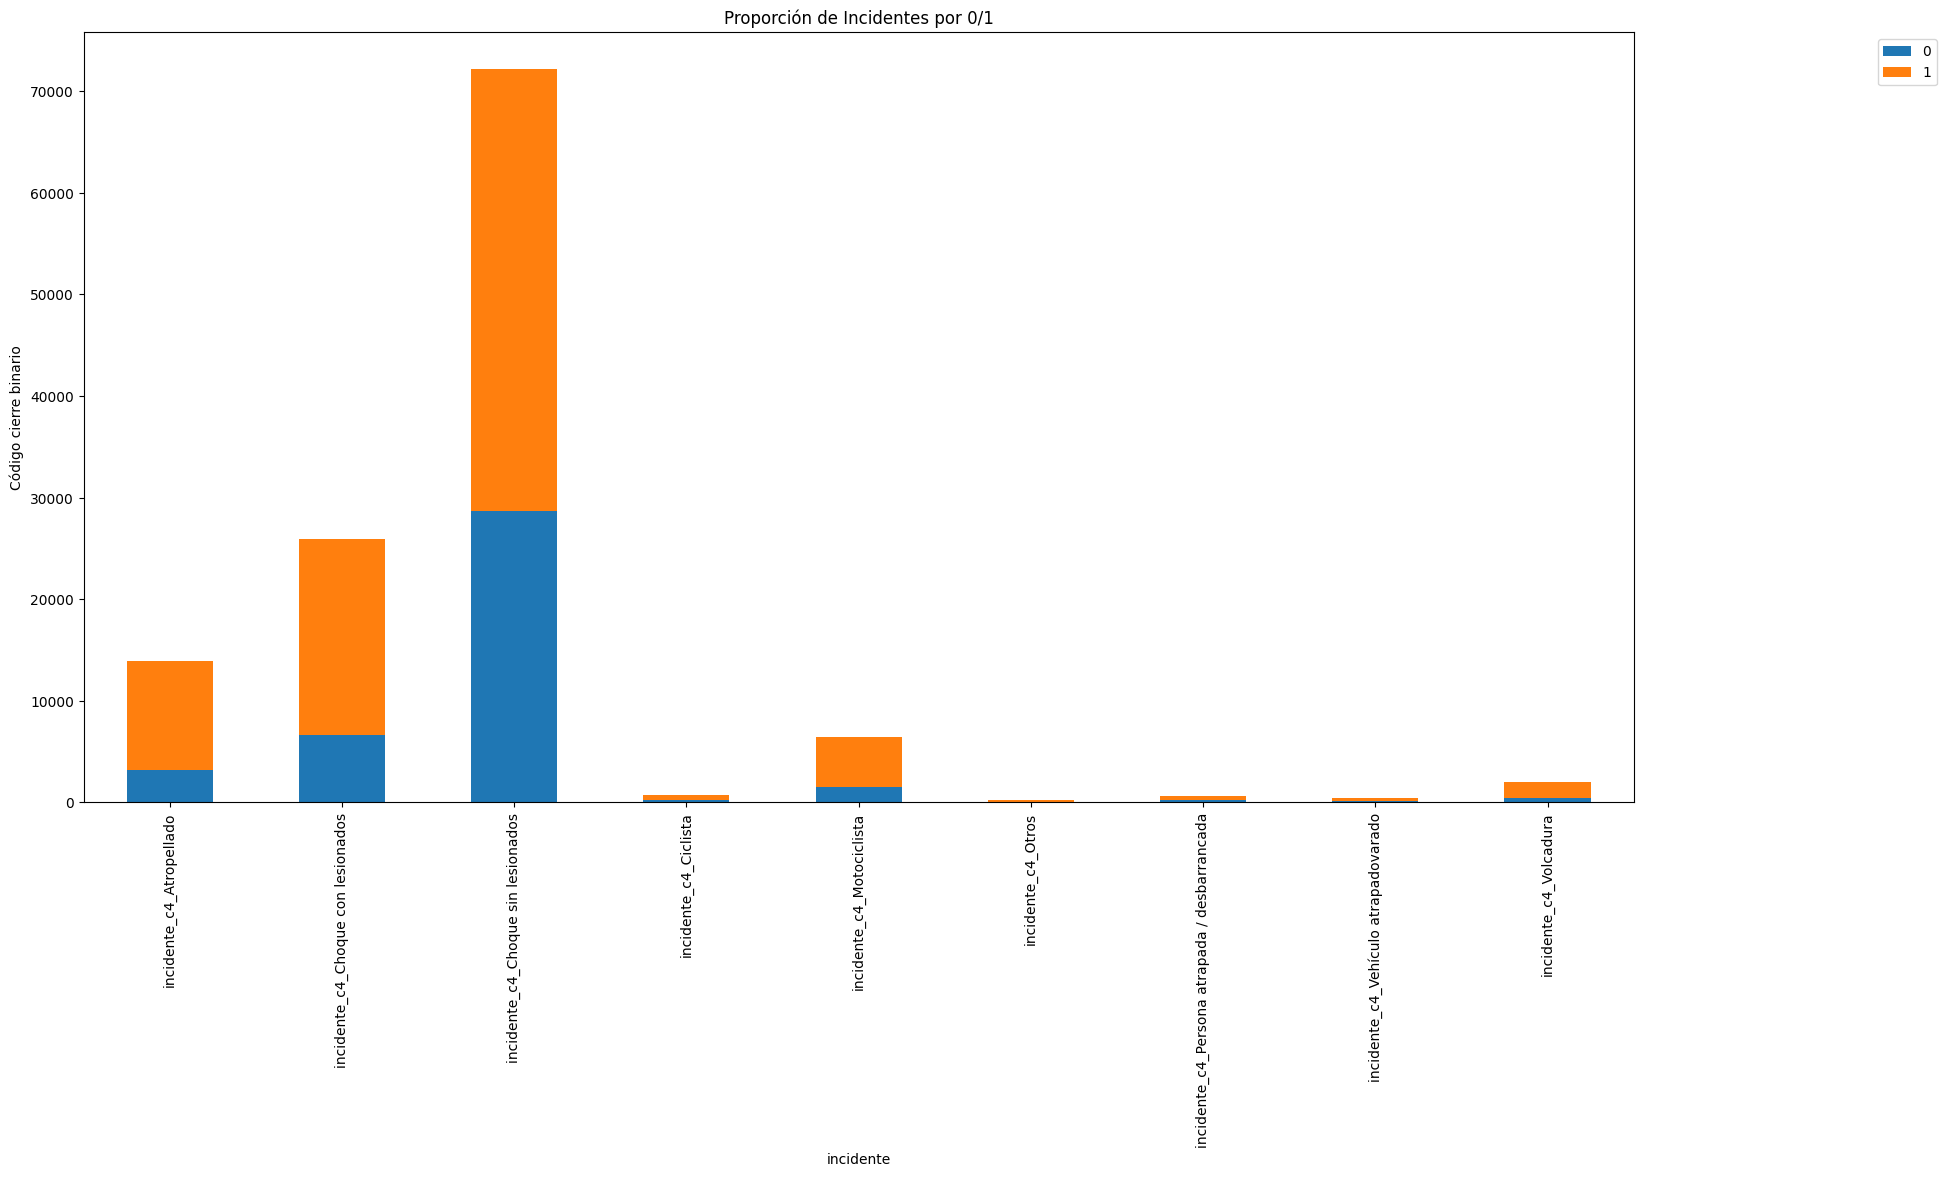

In [31]:
incidentes_segregados_t.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Proporción de Incidentes por 0/1')
plt.xlabel('incidente')
plt.ylabel('Código cierre binario')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Muestra la gráfica
plt.show()

In [42]:
incidentes_segregados_t['P(0)'] = incidentes_segregados_t[0]/(incidentes_segregados_t[0] + incidentes_segregados_t[1])
incidentes_segregados_t['P(1)'] = incidentes_segregados_t[1]/(incidentes_segregados_t[0] + incidentes_segregados_t[1])

incidentes_segregados_t

codigo_cierre_binario,0,1,P(0),P(1)
incidente_c4_Atropellado,3231.0,10653.0,0.232714,0.767286
incidente_c4_Choque con lesionados,6583.0,19331.0,0.254033,0.745967
incidente_c4_Choque sin lesionados,28683.0,43496.0,0.397387,0.602613
incidente_c4_Ciclista,182.0,568.0,0.242667,0.757333
incidente_c4_Motociclista,1556.0,4877.0,0.241878,0.758122
incidente_c4_Otros,40.0,190.0,0.173913,0.826087
incidente_c4_Persona atrapada / desbarrancada,209.0,454.0,0.315234,0.684766
incidente_c4_Vehículo atrapadovarado,145.0,254.0,0.363409,0.636591
incidente_c4_Volcadura,385.0,1621.0,0.191924,0.808076


In [44]:
incidentes_segregados_1 = data_sample2.groupby('codigo_cierre_binario').sum()[['tipo_incidente_c4_Accidente', 'tipo_incidente_c4_Cadáver',
       'tipo_incidente_c4_Lesionado']]

incidentes_segregados_1_t = incidentes_segregados_1.transpose()
incidentes_segregados_1_t

codigo_cierre_binario,0,1
tipo_incidente_c4_Accidente,37713.0,70288.0
tipo_incidente_c4_Cadáver,13.0,386.0
tipo_incidente_c4_Lesionado,3288.0,10770.0


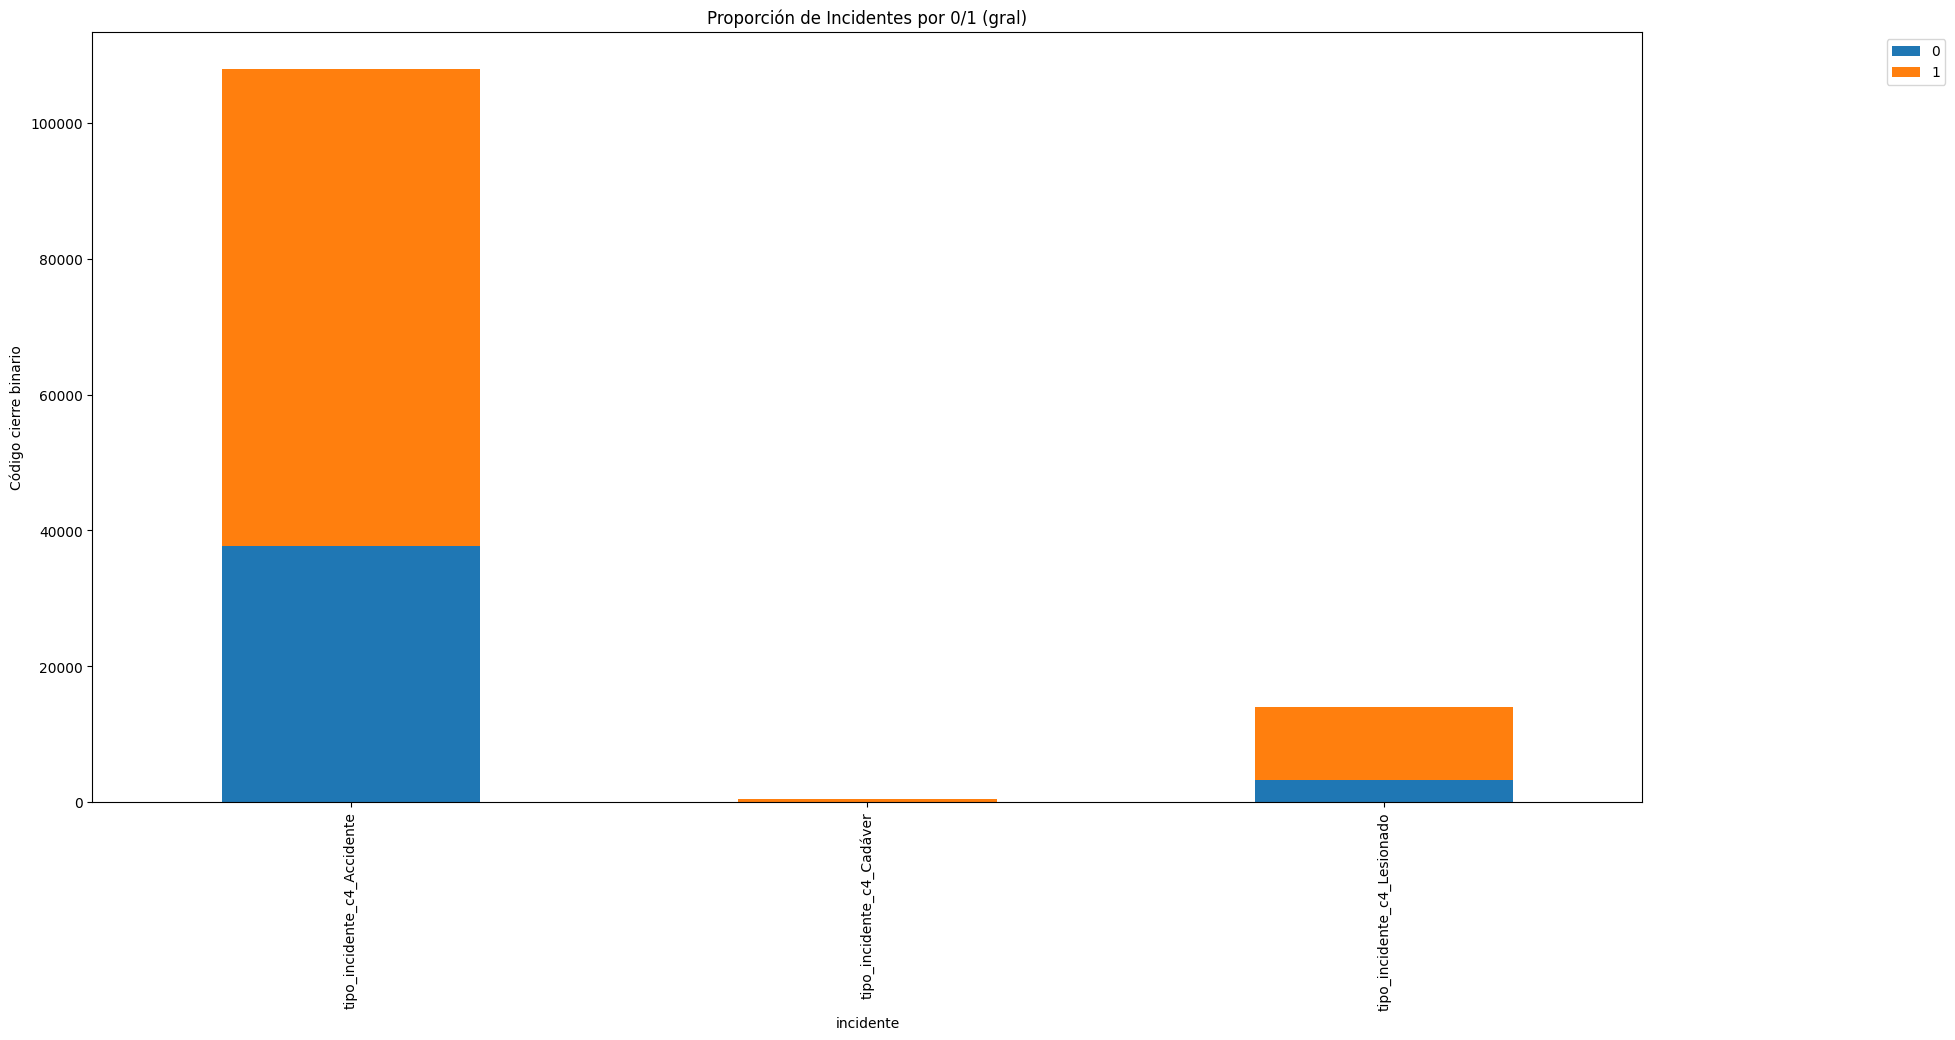

In [45]:
incidentes_segregados_1_t.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Proporción de Incidentes por 0/1 (gral)')
plt.xlabel('incidente')
plt.ylabel('Código cierre binario')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Muestra la gráfica
plt.show()

In [46]:
incidentes_segregados_1_t['P(0)'] = incidentes_segregados_1_t[0]/(incidentes_segregados_1_t[0] + incidentes_segregados_1_t[1])
incidentes_segregados_1_t['P(1)'] = incidentes_segregados_1_t[1]/(incidentes_segregados_1_t[0] + incidentes_segregados_1_t[1])

incidentes_segregados_1_t

codigo_cierre_binario,0,1,P(0),P(1)
tipo_incidente_c4_Accidente,37713.0,70288.0,0.349191,0.650809
tipo_incidente_c4_Cadáver,13.0,386.0,0.032581,0.967419
tipo_incidente_c4_Lesionado,3288.0,10770.0,0.233888,0.766112


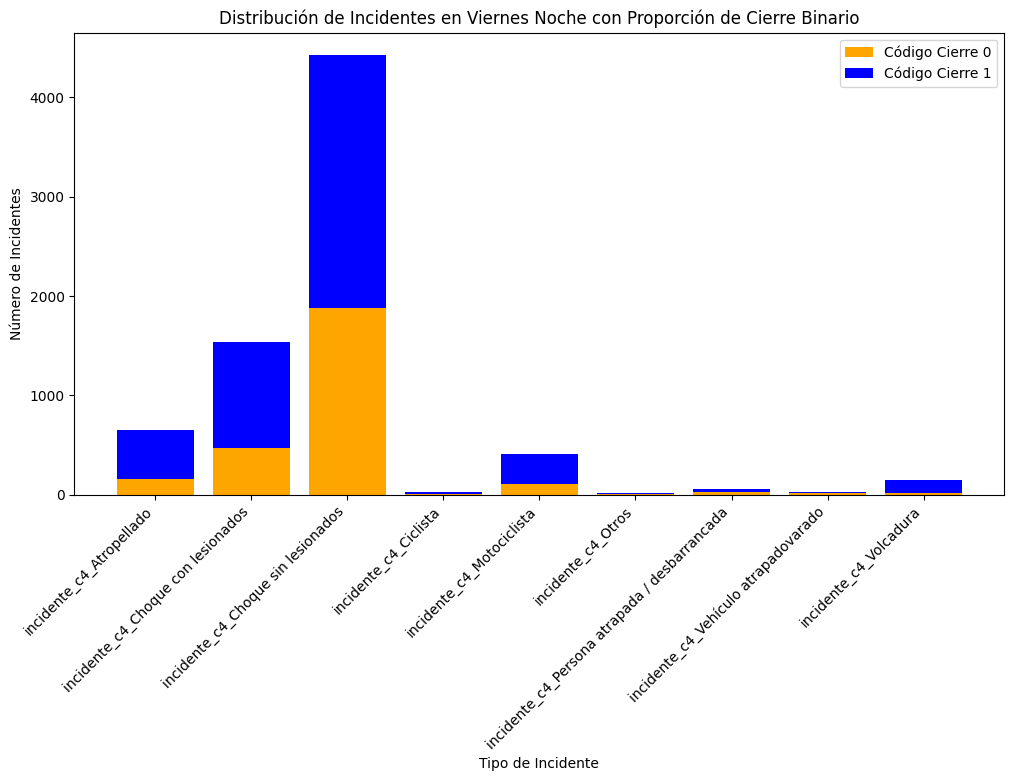

In [61]:
data_viernes_noche = data_sample2[data_sample2['viernes_noche'] == 1]

# Seleccionar las columnas relevantes
columnas_incidentes = ['incidente_c4_Atropellado', 'incidente_c4_Choque con lesionados',
                        'incidente_c4_Choque sin lesionados', 'incidente_c4_Ciclista',
                        'incidente_c4_Motociclista', 'incidente_c4_Otros',
                        'incidente_c4_Persona atrapada / desbarrancada',
                        'incidente_c4_Vehículo atrapadovarado', 'incidente_c4_Volcadura']

suma_incidentes = data_viernes_noche[columnas_incidentes].sum()

# Contar la cantidad de incidentes con 'codigo_cierre_binario' en 0 y 1
incidentes_0 = data_viernes_noche[data_viernes_noche['codigo_cierre_binario'] == 0][columnas_incidentes].sum()
incidentes_1 = data_viernes_noche[data_viernes_noche['codigo_cierre_binario'] == 1][columnas_incidentes].sum()

# Configurar el gráfico de barras apiladas
plt.figure(figsize=(12, 6))
bar_positions = range(len(suma_incidentes.index))

plt.bar(bar_positions, incidentes_0, label='Código Cierre 0', color='orange')
plt.bar(bar_positions, incidentes_1, bottom=incidentes_0, label='Código Cierre 1', color='blue')

# Configuración del gráfico
plt.xlabel('Tipo de Incidente')
plt.ylabel('Número de Incidentes')
plt.title('Distribución de Incidentes en Viernes Noche con Proporción de Cierre Binario')
plt.xticks(bar_positions, suma_incidentes.index, rotation=45, ha="right")
plt.legend()

# Mostrar el gráfico
plt.show()

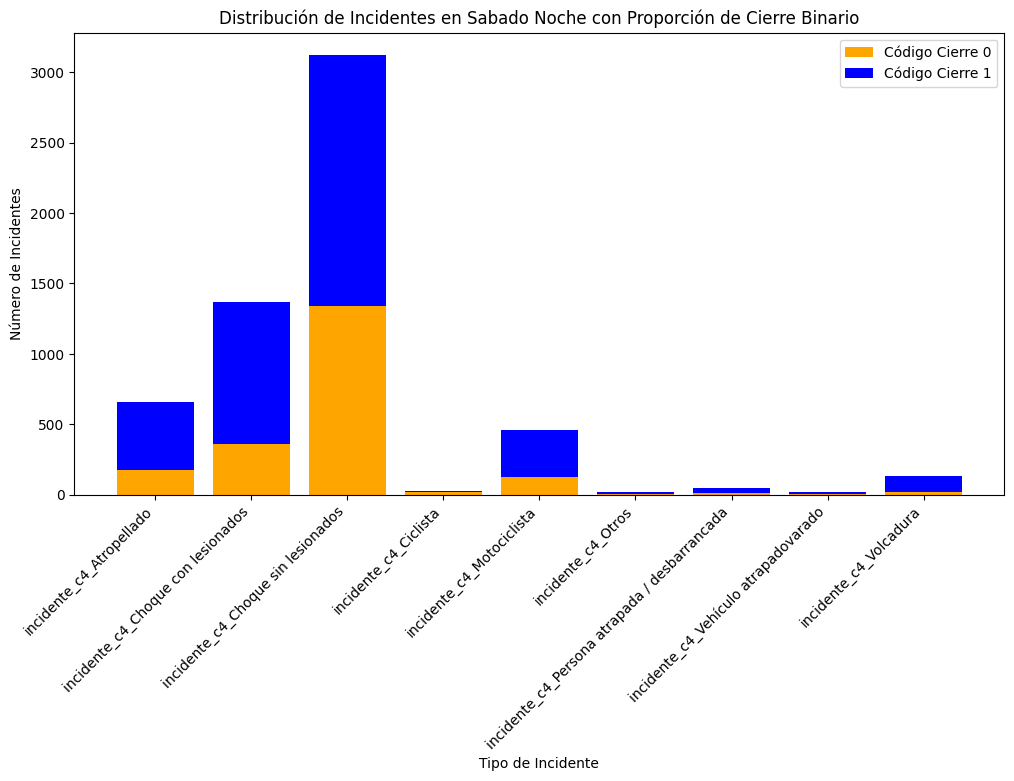

In [65]:
data_sabado_noche = data_sample2[data_sample2['sabado_noche'] == 1]

# Seleccionar las columnas relevantes
columnas_incidentes = ['incidente_c4_Atropellado', 'incidente_c4_Choque con lesionados',
                        'incidente_c4_Choque sin lesionados', 'incidente_c4_Ciclista',
                        'incidente_c4_Motociclista', 'incidente_c4_Otros',
                        'incidente_c4_Persona atrapada / desbarrancada',
                        'incidente_c4_Vehículo atrapadovarado', 'incidente_c4_Volcadura']

suma_incidentes = data_sabado_noche[columnas_incidentes].sum()

# Contar la cantidad de incidentes con 'codigo_cierre_binario' en 0 y 1
incidentes_0 = data_sabado_noche[data_sabado_noche['codigo_cierre_binario'] == 0][columnas_incidentes].sum()
incidentes_1 = data_sabado_noche[data_sabado_noche['codigo_cierre_binario'] == 1][columnas_incidentes].sum()

# Configurar el gráfico de barras apiladas
plt.figure(figsize=(12, 6))
bar_positions = range(len(suma_incidentes.index))

plt.bar(bar_positions, incidentes_0, label='Código Cierre 0', color='orange')
plt.bar(bar_positions, incidentes_1, bottom=incidentes_0, label='Código Cierre 1', color='blue')

# Configuración del gráfico
plt.xlabel('Tipo de Incidente')
plt.ylabel('Número de Incidentes')
plt.title('Distribución de Incidentes en Sabado Noche con Proporción de Cierre Binario')
plt.xticks(bar_positions, suma_incidentes.index, rotation=45, ha="right")
plt.legend()

# Mostrar el gráfico
plt.show()

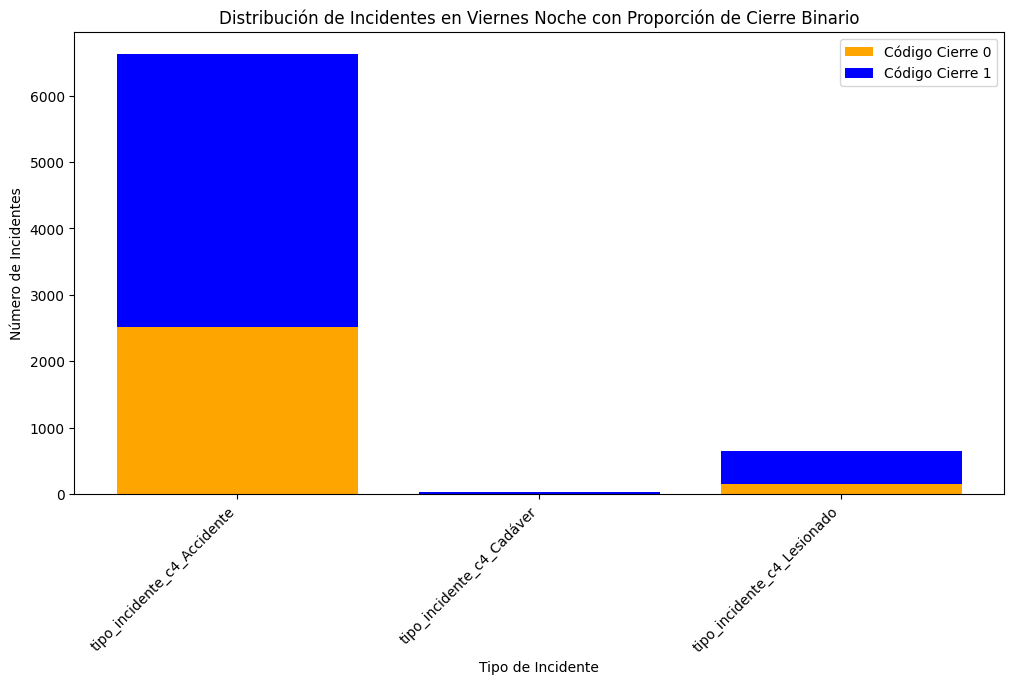

In [66]:
data_viernes_noche1 = data_sample2[data_sample2['viernes_noche'] == 1]

# Seleccionar las columnas relevantes
columnas_incidentes = ['tipo_incidente_c4_Accidente', 'tipo_incidente_c4_Cadáver', 'tipo_incidente_c4_Lesionado']

# Calcular la suma de cada tipo de incidente
suma_incidentes = data_viernes_noche1[columnas_incidentes].sum()

# Contar la cantidad de incidentes con 'codigo_cierre_binario' en 0 y 1
incidentes_0 = data_viernes_noche1[data_viernes_noche1['codigo_cierre_binario'] == 0][columnas_incidentes].sum()
incidentes_1 = data_viernes_noche1[data_viernes_noche1['codigo_cierre_binario'] == 1][columnas_incidentes].sum()

# Configurar el gráfico de barras apiladas
plt.figure(figsize=(12, 6))
bar_positions = range(len(suma_incidentes.index))

plt.bar(bar_positions, incidentes_0, label='Código Cierre 0', color='orange')
plt.bar(bar_positions, incidentes_1, bottom=incidentes_0, label='Código Cierre 1', color='blue')

# Configuración del gráfico
plt.xlabel('Tipo de Incidente')
plt.ylabel('Número de Incidentes')
plt.title('Distribución de Incidentes en Viernes Noche con Proporción de Cierre Binario')
plt.xticks(bar_positions, suma_incidentes.index, rotation=45, ha="right")
plt.legend()

# Mostrar el gráfico
plt.show()

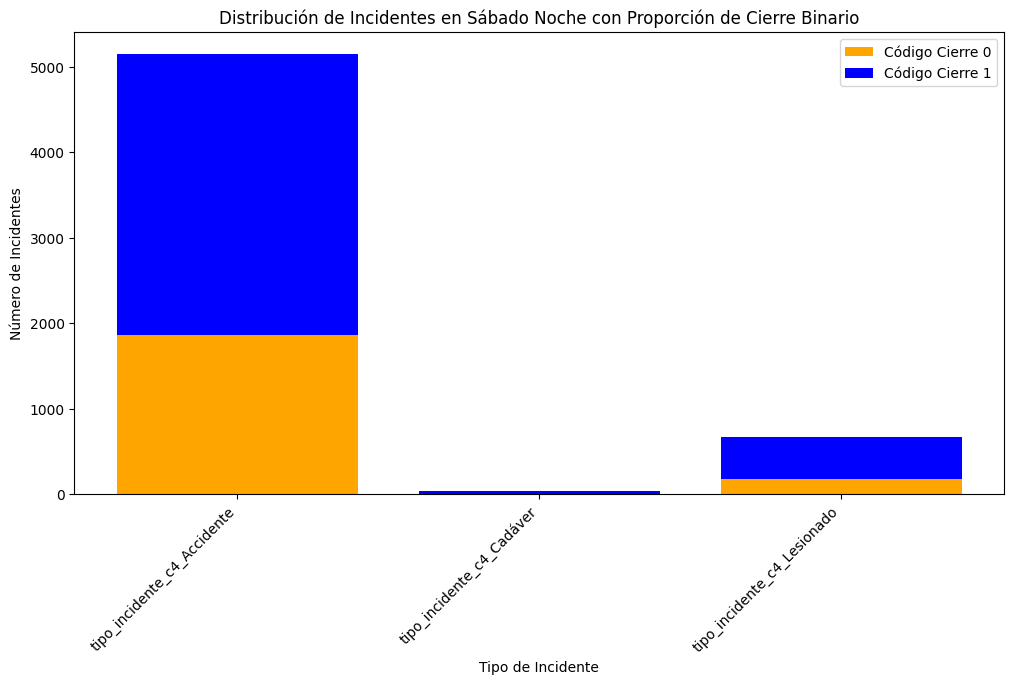

In [67]:
data_sabado_noche1 = data_sample2[data_sample2['sabado_noche'] == 1]

# Seleccionar las columnas relevantes
columnas_incidentes = ['tipo_incidente_c4_Accidente', 'tipo_incidente_c4_Cadáver', 'tipo_incidente_c4_Lesionado']

# Calcular la suma de cada tipo de incidente
suma_incidentes = data_sabado_noche1[columnas_incidentes].sum()

# Contar la cantidad de incidentes con 'codigo_cierre_binario' en 0 y 1
incidentes_0 = data_sabado_noche1[data_sabado_noche1['codigo_cierre_binario'] == 0][columnas_incidentes].sum()
incidentes_1 = data_sabado_noche1[data_sabado_noche1['codigo_cierre_binario'] == 1][columnas_incidentes].sum()

# Configurar el gráfico de barras apiladas
plt.figure(figsize=(12, 6))
bar_positions = range(len(suma_incidentes.index))

plt.bar(bar_positions, incidentes_0, label='Código Cierre 0', color='orange')
plt.bar(bar_positions, incidentes_1, bottom=incidentes_0, label='Código Cierre 1', color='blue')

# Configuración del gráfico
plt.xlabel('Tipo de Incidente')
plt.ylabel('Número de Incidentes')
plt.title('Distribución de Incidentes en Sábado Noche con Proporción de Cierre Binario')
plt.xticks(bar_positions, suma_incidentes.index, rotation=45, ha="right")
plt.legend()

# Mostrar el gráfico
plt.show()

In [8]:
data.loc[data['codigo_cierre_binario'] == 1]

,fecha_creacion,hora_creacion,latitud,longitud,codigo_cierre,fin_semana,sin_enc_hora_creacion,cos_enc_hora_creacion,hora_pico,dia_festivo,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miércoles,dia_semana_Sábado,dia_semana_Viernes,tipo_entrada_BOTÓN DE AUXILIO,tipo_entrada_CÁMARA,tipo_entrada_LLAMADA DEL 911,tipo_entrada_RADIO,tipo_entrada_REDES,alcaldia_inicio_ALVARO OBREGON,alcaldia_inicio_AZCAPOTZALCO,alcaldia_inicio_BENITO JUAREZ,alcaldia_inicio_COYOACAN,alcaldia_inicio_CUAJIMALPA DE MORELOS,alcaldia_inicio_CUAUHTEMOC,alcaldia_inicio_GUSTAVO A. MADERO,alcaldia_inicio_IZTACALCO,alcaldia_inicio_IZTAPALAPA,alcaldia_inicio_LA MAGDALENA CONTRERAS,alcaldia_inicio_MIGUEL HIDALGO,alcaldia_inicio_MILPA ALTA,alcaldia_inicio_TLAHUAC,alcaldia_inicio_TLALPAN,alcaldia_inicio_VENUSTIANO CARRANZA,alcaldia_inicio_XOCHIMILCO,tipo_incidente_c4_Accidente,tipo_incidente_c4_Cadáver,tipo_incidente_c4_Lesionado,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura,codigo_cierre_binario
0,2014-01-01,13.413333,19.380900,-99.061040,A,0,-0.361625,-0.932324,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2014-01-01,21.749722,19.490530,-99.103420,A,0,-0.555631,0.831429,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2014-01-01,21.761944,19.363360,-99.191040,A,0,-0.552967,0.833203,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,2014-01-01,19.791111,19.295440,-99.054880,A,0,-0.892061,0.451916,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,2013-12-31,19.821944,19.482380,-99.197810,A,0,-0.888384,0.459102,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974170,2023-07-31,20.161944,19.444458,-99.211365,A,0,-0.844055,0.536257,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1974173,2023-07-31,19.950833,19.340133,-99.131814,A,0,-0.872389,0.488812,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1974174,2023-07-31,19.981389,19.438670,-99.212280,A,0,-0.868451,0.495774,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1974176,2023-07-31,0.163611,19.373010,-99.263510,A,0,0.042820,0.999083,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [9]:
data.loc[data['codigo_cierre_binario'] == 0]

,fecha_creacion,hora_creacion,latitud,longitud,codigo_cierre,fin_semana,sin_enc_hora_creacion,cos_enc_hora_creacion,hora_pico,dia_festivo,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miércoles,dia_semana_Sábado,dia_semana_Viernes,tipo_entrada_BOTÓN DE AUXILIO,tipo_entrada_CÁMARA,tipo_entrada_LLAMADA DEL 911,tipo_entrada_RADIO,tipo_entrada_REDES,alcaldia_inicio_ALVARO OBREGON,alcaldia_inicio_AZCAPOTZALCO,alcaldia_inicio_BENITO JUAREZ,alcaldia_inicio_COYOACAN,alcaldia_inicio_CUAJIMALPA DE MORELOS,alcaldia_inicio_CUAUHTEMOC,alcaldia_inicio_GUSTAVO A. MADERO,alcaldia_inicio_IZTACALCO,alcaldia_inicio_IZTAPALAPA,alcaldia_inicio_LA MAGDALENA CONTRERAS,alcaldia_inicio_MIGUEL HIDALGO,alcaldia_inicio_MILPA ALTA,alcaldia_inicio_TLAHUAC,alcaldia_inicio_TLALPAN,alcaldia_inicio_VENUSTIANO CARRANZA,alcaldia_inicio_XOCHIMILCO,tipo_incidente_c4_Accidente,tipo_incidente_c4_Cadáver,tipo_incidente_c4_Lesionado,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura,codigo_cierre_binario
2,2013-12-31,22.053611,19.322760,-99.048300,I,0,-0.487796,0.872958,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2013-12-31,22.748056,19.314690,-99.071130,I,0,-0.321921,0.946766,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,2013-12-31,22.243611,19.326870,-99.068880,I,0,-0.443788,0.896132,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,2014-01-01,18.028611,19.310150,-99.108050,N,0,-0.999972,0.007490,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
12,2013-12-31,22.549444,19.318400,-99.075500,I,0,-0.370693,0.928756,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974157,2023-07-31,15.330556,19.378855,-99.241238,F,0,-0.765577,-0.643345,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1974159,2023-07-31,16.011111,19.385389,-99.051714,F,0,-0.867476,-0.497479,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1974169,2023-07-31,20.341111,19.515723,-99.135072,F,0,-0.817982,0.575243,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1974172,2023-07-31,20.091944,19.267510,-99.146010,F,0,-0.853740,0.520699,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [10]:
ratio = 0.5
sample_0 = data[data['codigo_cierre_binario'] == 0]
sample_1 = data[data['codigo_cierre_binario'] == 1].sample(frac=0.5)
sample_for_test = pd.concat([sample_0, sample_1])

# Barajar las filas para obtener una mezcla aleatoria
sample_for_test = sample_for_test.sample(frac=1).reset_index(drop=True)
sample_for_test.head()

,fecha_creacion,hora_creacion,latitud,longitud,codigo_cierre,fin_semana,sin_enc_hora_creacion,cos_enc_hora_creacion,hora_pico,dia_festivo,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miércoles,dia_semana_Sábado,dia_semana_Viernes,tipo_entrada_BOTÓN DE AUXILIO,tipo_entrada_CÁMARA,tipo_entrada_LLAMADA DEL 911,tipo_entrada_RADIO,tipo_entrada_REDES,alcaldia_inicio_ALVARO OBREGON,alcaldia_inicio_AZCAPOTZALCO,alcaldia_inicio_BENITO JUAREZ,alcaldia_inicio_COYOACAN,alcaldia_inicio_CUAJIMALPA DE MORELOS,alcaldia_inicio_CUAUHTEMOC,alcaldia_inicio_GUSTAVO A. MADERO,alcaldia_inicio_IZTACALCO,alcaldia_inicio_IZTAPALAPA,alcaldia_inicio_LA MAGDALENA CONTRERAS,alcaldia_inicio_MIGUEL HIDALGO,alcaldia_inicio_MILPA ALTA,alcaldia_inicio_TLAHUAC,alcaldia_inicio_TLALPAN,alcaldia_inicio_VENUSTIANO CARRANZA,alcaldia_inicio_XOCHIMILCO,tipo_incidente_c4_Accidente,tipo_incidente_c4_Cadáver,tipo_incidente_c4_Lesionado,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura,codigo_cierre_binario
0,2022-07-18,14.883611,19.321073,-99.113858,F,0,-0.685236,-0.728321,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2014-08-19,14.389444,19.395470,-99.137910,A,0,-0.585547,-0.810638,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2023-04-21,16.603611,19.379737,-99.244978,A,0,-0.933919,-0.357485,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2019-06-27,23.519167,19.422380,-99.107860,A,0,-0.125550,0.992087,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2020-09-08,8.086667,19.339650,-99.199740,A,0,0.854459,-0.519519,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
sample_for_test.shape

(816143, 51)

In [12]:
sample_for_test['codigo_cierre_binario'].value_counts()


codigo_cierre_binario
1    408432
0    407711
Name: count, dtype: int64

In [13]:
# for c in data.columns:
#     print(c)

In [14]:
# sns.countplot(x='alcaldia_inicio', data=data_original, hue='codigo_cierre', order=data_original['alcaldia_inicio'].value_counts().index)
# plt.xticks(rotation=90) 
# plt.tight_layout() 

In [15]:
y = data['codigo_cierre_binario']
X = data[['hora_creacion', 'latitud', 'longitud']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# # Scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)



In [16]:
y_test.value_counts()

codigo_cierre_binario
1    245086
0    122287
Name: count, dtype: int64

In [17]:
pd.DataFrame(X_resampled, columns= ['hora_creacion', 'latitud', 'longitud'])

,hora_creacion,latitud,longitud
0,0.365872,0.985796,0.002509
1,0.008449,0.991172,0.002740
2,0.625702,0.988906,0.002268
3,0.276369,0.980707,0.003133
4,0.786074,0.980419,0.002505
...,...,...,...
1143551,0.935292,0.985623,0.003543
1143552,0.369806,0.984176,0.003053
1143553,0.614727,0.982508,0.002280
1143554,0.904629,0.992819,0.002192


In [18]:
y_resampled.value_counts()

codigo_cierre_binario
1    571778
0    571778
Name: count, dtype: int64

In [19]:
model = LogisticRegression(solver='newton-cg').fit(X_resampled, y_resampled)

accuracy = model.score(X_test_scaled, y_test)

accuracy

0.5414823626123858

In [20]:
from sklearn.metrics import recall_score
y_pred = model.predict(X_test_scaled)
recall = recall_score(y_test, y_pred)
recall

0.5371910268232376

In [21]:
X2 = data.drop(columns=['fecha_creacion', 'hora_creacion', 'codigo_cierre', 'codigo_cierre_binario'])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.3)

# # Scaler
scaler = MinMaxScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

smote = SMOTE(random_state=42)
X2_resampled, y2_resampled = smote.fit_resample(X2_train_scaled, y2_train)

In [22]:
X2.head()

,latitud,longitud,fin_semana,sin_enc_hora_creacion,cos_enc_hora_creacion,hora_pico,dia_festivo,dia_semana_Domingo,dia_semana_Jueves,dia_semana_Lunes,dia_semana_Martes,dia_semana_Miércoles,dia_semana_Sábado,dia_semana_Viernes,tipo_entrada_BOTÓN DE AUXILIO,tipo_entrada_CÁMARA,tipo_entrada_LLAMADA DEL 911,tipo_entrada_RADIO,tipo_entrada_REDES,alcaldia_inicio_ALVARO OBREGON,alcaldia_inicio_AZCAPOTZALCO,alcaldia_inicio_BENITO JUAREZ,alcaldia_inicio_COYOACAN,alcaldia_inicio_CUAJIMALPA DE MORELOS,alcaldia_inicio_CUAUHTEMOC,alcaldia_inicio_GUSTAVO A. MADERO,alcaldia_inicio_IZTACALCO,alcaldia_inicio_IZTAPALAPA,alcaldia_inicio_LA MAGDALENA CONTRERAS,alcaldia_inicio_MIGUEL HIDALGO,alcaldia_inicio_MILPA ALTA,alcaldia_inicio_TLAHUAC,alcaldia_inicio_TLALPAN,alcaldia_inicio_VENUSTIANO CARRANZA,alcaldia_inicio_XOCHIMILCO,tipo_incidente_c4_Accidente,tipo_incidente_c4_Cadáver,tipo_incidente_c4_Lesionado,incidente_c4_Atropellado,incidente_c4_Choque con lesionados,incidente_c4_Choque sin lesionados,incidente_c4_Ciclista,incidente_c4_Motociclista,incidente_c4_Otros,incidente_c4_Persona atrapada / desbarrancada,incidente_c4_Vehículo atrapadovarado,incidente_c4_Volcadura
0,19.38090,-99.06104,0,-0.361625,-0.932324,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19.49053,-99.10342,0,-0.555631,0.831429,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19.32276,-99.04830,0,-0.487796,0.872958,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,19.31469,-99.07113,0,-0.321921,0.946766,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19.36336,-99.19104,0,-0.552967,0.833203,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
model2 = LogisticRegression(solver='newton-cg').fit(X2_resampled, y2_resampled)

accuracy2 = model2.score(X2_test_scaled, y2_test)

accuracy2

0.5914860373516835

In [24]:
y2_test[:10]

40482      1
1346704    0
1790969    0
1843252    1
1411176    0
833542     1
691941     1
267677     1
386735     1
1095870    1
Name: codigo_cierre_binario, dtype: int64

In [25]:
model2.predict(X2_test_scaled)[:10]

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0])

In [26]:
y2_resampled.value_counts()

codigo_cierre_binario
1    571681
0    571681
Name: count, dtype: int64

In [27]:
y2_pred = model2.predict(X2_test_scaled)
recall = recall_score(y2_test, y2_pred)
recall
#model2.predict(X2_scaled).mean()

0.5175603528792779

In [28]:
data_scaled1 = pd.DataFrame(X2_resampled, columns=["latitud", "longitud", "fin_semana", "sin_enc_hora_creacion", "cos_enc_hora_creacion", "hora_pico", "dia_festivo", "dia_semana_Domingo", "dia_semana_Jueves", "dia_semana_Lunes", "dia_semana_Martes", "dia_semana_Miércoles", "dia_semana_Sábado", "dia_semana_Viernes", "tipo_entrada_BOTÓN DE AUXILIO", "tipo_entrada_CÁMARA", "tipo_entrada_LLAMADA DEL 911", "tipo_entrada_RADIO", "tipo_entrada_REDES", "alcaldia_inicio_ALVARO OBREGON", "alcaldia_inicio_AZCAPOTZALCO", "alcaldia_inicio_BENITO JUAREZ", "alcaldia_inicio_COYOACAN", "alcaldia_inicio_CUAJIMALPA DE MORELOS", "alcaldia_inicio_CUAUHTEMOC", "alcaldia_inicio_GUSTAVO A. MADERO", "alcaldia_inicio_IZTACALCO", "alcaldia_inicio_IZTAPALAPA", "alcaldia_inicio_LA MAGDALENA CONTRERAS", "alcaldia_inicio_MIGUEL HIDALGO", "alcaldia_inicio_MILPA ALTA", "alcaldia_inicio_TLAHUAC", "alcaldia_inicio_TLALPAN", "alcaldia_inicio_VENUSTIANO CARRANZA", "alcaldia_inicio_XOCHIMILCO", "tipo_incidente_c4_Accidente", "tipo_incidente_c4_Cadáver", "tipo_incidente_c4_Lesionado", "incidente_c4_Atropellado", "incidente_c4_Choque con lesionados", "incidente_c4_Choque sin lesionados", "incidente_c4_Ciclista", "incidente_c4_Motociclista", "incidente_c4_Otros", "incidente_c4_Persona atrapada / desbarrancada", "incidente_c4_Vehículo atrapado/varado", "incidente_c4_Volcadura"])


In [29]:
permutation_score = permutation_importance(model2, X2_resampled, y2_resampled, n_repeats=10)

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((data_scaled1.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False)

,feature,score decrease
35,tipo_incidente_c4_Accidente,0.024639
40,incidente_c4_Choque sin lesionados,0.023916
16,tipo_entrada_LLAMADA DEL 911,0.020258
17,tipo_entrada_RADIO,0.00552
24,alcaldia_inicio_CUAUHTEMOC,0.004751
3,sin_enc_hora_creacion,0.00433
14,tipo_entrada_BOTÓN DE AUXILIO,0.003805
46,incidente_c4_Volcadura,0.002579
38,incidente_c4_Atropellado,0.002473
37,tipo_incidente_c4_Lesionado,0.002364


In [30]:
pd.set_option('display.max_rows', len(importance_df))
importance_df.sort_values(by="score decrease", ascending = False)

,feature,score decrease
35,tipo_incidente_c4_Accidente,0.024639
40,incidente_c4_Choque sin lesionados,0.023916
16,tipo_entrada_LLAMADA DEL 911,0.020258
17,tipo_entrada_RADIO,0.00552
24,alcaldia_inicio_CUAUHTEMOC,0.004751
3,sin_enc_hora_creacion,0.00433
14,tipo_entrada_BOTÓN DE AUXILIO,0.003805
46,incidente_c4_Volcadura,0.002579
38,incidente_c4_Atropellado,0.002473
37,tipo_incidente_c4_Lesionado,0.002364


<Axes: >

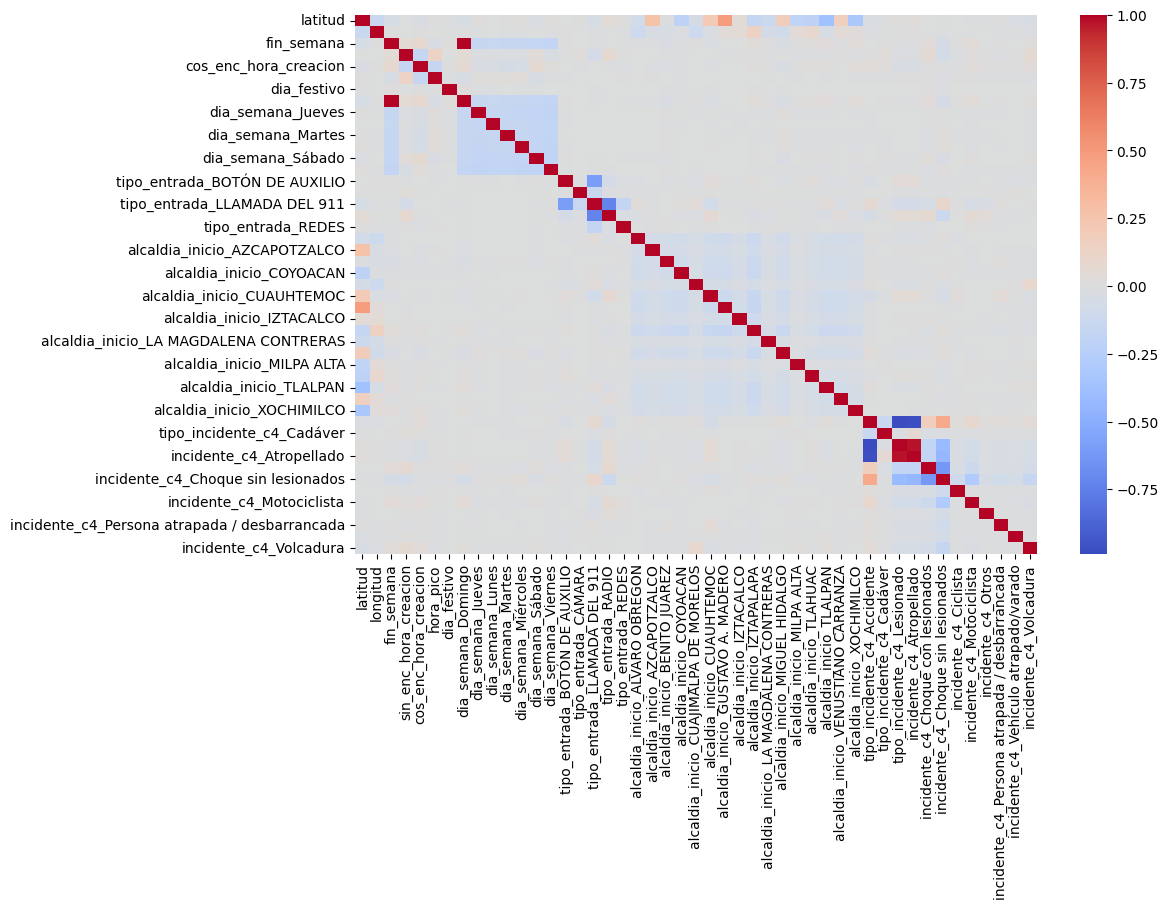

In [31]:
plt.figure(figsize=(11,7))
sns.heatmap(data_scaled1.corr(), cmap='coolwarm')

In [32]:
data_corr = data_scaled1[['tipo_incidente_c4_Accidente', 'tipo_incidente_c4_Lesionado', 'tipo_entrada_LLAMADA DEL 911', 'tipo_entrada_RADIO']]

In [33]:
data_corr

,tipo_incidente_c4_Accidente,tipo_incidente_c4_Lesionado,tipo_entrada_LLAMADA DEL 911,tipo_entrada_RADIO
0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0
...,...,...,...,...
1143357,1.0,0.0,1.0,0.0
1143358,1.0,0.0,1.0,0.0
1143359,1.0,0.0,0.0,1.0
1143360,1.0,0.0,1.0,0.0


<Axes: >

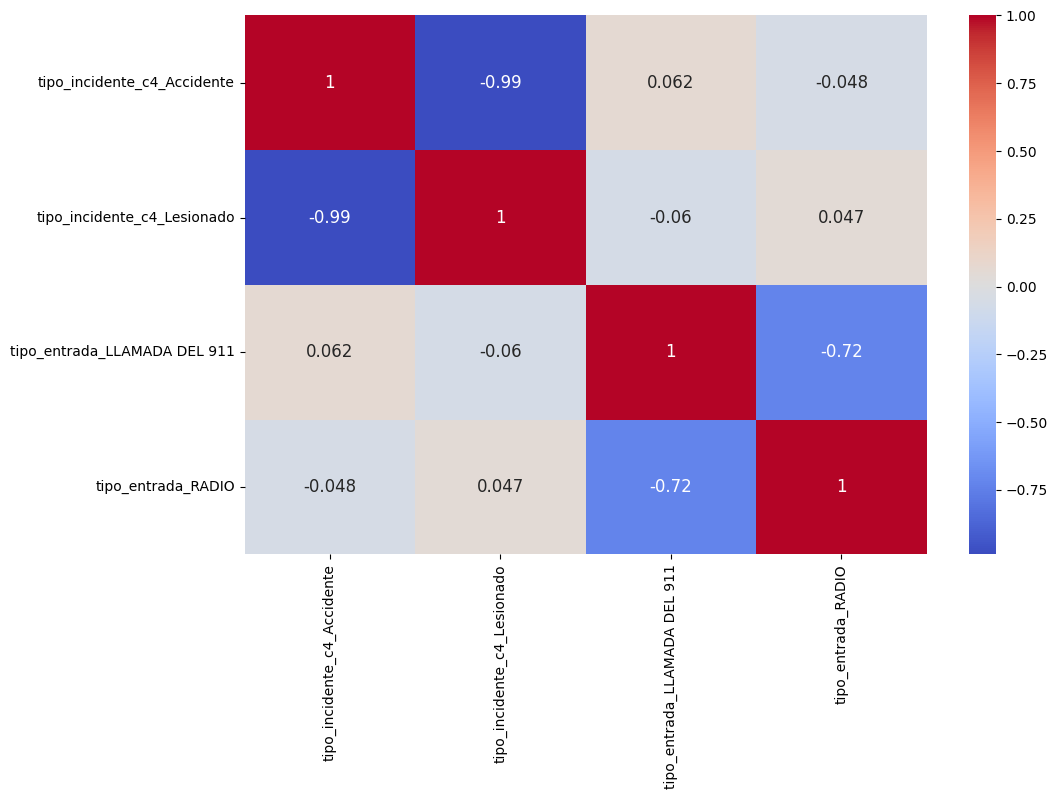

In [34]:
plt.figure(figsize=(11,7))
sns.heatmap(data_corr.corr(), cmap='coolwarm', annot = True, annot_kws={"size": 12})